<a href="https://colab.research.google.com/github/5655555/AI/blob/main/%E8%AE%93_AI_%E8%A9%95%E4%BC%B0%E6%8A%95%E8%B3%87%E7%B5%84%E5%90%88%E9%A2%A8%E9%9A%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 讓 AI 評估投資組合風險

## 資料爬蟲

## 證交所資料爬蟲
1. 進入證交所網址：https://www.twse.com.tw/zh/index.html
2. 使用開發者模式取得請求資料網址

### 1️⃣ 匯入套件

In [168]:
import requests
import pandas as pd
import datetime as dt # 時間套件
from dateutil.relativedelta import relativedelta

### 2️⃣ 取得個股日成交資訊

In [169]:
# 輸入股票代號
stock_id = '2330'
# 當日時間
date = dt.date.today().strftime("%Y%m%d")
# 取得證交所網站資料
stock_data = requests.get(f'https://www.twse.com.tw/rwd/zh/ \
            afterTrading/STOCK_DAY?date={date}&stockNo={stock_id}')
json_data = stock_data.json()
df = pd.DataFrame(data=json_data['data'],
                  columns=json_data['fields'])
df.tail()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
6,114/01/10,"24,475,751","26,996,697,889","1,100.00","1,110.00","1,100.00","1,100.00",0.00,"38,027"
7,114/01/13,"62,629,547","68,093,421,797","1,110.00","1,115.00","1,070.00","1,075.00",-25.00,"118,516"
8,114/01/14,"31,280,235","33,915,048,410","1,085.00","1,090.00","1,075.00","1,090.00",+15.00,"32,218"
9,114/01/15,"37,966,582","40,677,529,813","1,085.00","1,085.00","1,065.00","1,065.00",-25.00,"74,906"
10,114/01/16,"49,872,673","54,934,128,041","1,095.00","1,115.00","1,090.00","1,105.00",+40.00,"54,389"


### 3️⃣ 取得連續月份資料
以個股本益比為例

In [170]:
# 設定抓取幾個月資料
month_num=3
date_now = dt.datetime.now()

# 建立日期串列
date_list = [(date_now - relativedelta(months=i)).replace(day=1).\
             strftime('%Y%m%d') for i in range(month_num)]

date_list.reverse()
all_df = pd.DataFrame()

# 使用迴圈抓取連續日期資料
for date in date_list:
  url = f'https://www.twse.com.tw/rwd/zh/afterTrading/\
      BWIBBU?date={date}&stockNo={stock_id}'
  try:
    json_data = requests.get(url).json()
    df = pd.DataFrame(data=json_data['data'],
                  columns=json_data['fields'])
    all_df = pd.concat([all_df, df], ignore_index=True)
  except Exception as e:
    print(f"無法取得{date}的資料, 可能資料量不足.")

all_df.head()

,日期,殖利率(%),股利年度,本益比,股價淨值比,財報年/季
0,113年11月01日,1.27,112,28.79,7.01,113/2
1,113年11月04日,1.25,112,29.21,7.11,113/2
2,113年11月05日,1.24,112,29.49,7.18,113/2
3,113年11月06日,1.23,112,29.78,7.25,113/2
4,113年11月07日,1.22,112,29.92,7.28,113/2


## 用 BeautifulSoup4 取得 Yahoo 股市資料

###4️⃣ 匯入套件

In [171]:
from datetime import datetime
from bs4 import BeautifulSoup
import time

###  5️⃣ 取得當日股價

In [172]:
def yahoo_stock(stock_id):
    url = f'https://tw.stock.yahoo.com/quote/{stock_id}.TW'
    # 使用 requests 取得網頁內容
    response = requests.get(url)
    html = response.content
    # 使用 Beautiful Soup 解析 HTML 內容
    soup = BeautifulSoup(html, 'html.parser')
    # 使用 find 與 find_all 定位元素
    time_element = soup.find('section',\
                {'id': 'qsp-overview-realtime-info'}).find('time')
    table_soups = soup.find('section',\
                {'id': 'qsp-overview-realtime-info'}).find('ul')\
                                   .find_all('li')
    fields = []
    datas = []
    for table_soup in table_soups:
        table_datas = table_soup.find_all('span')
        for num,table_data in enumerate(table_datas):
            if table_data.text =='':
                continue
            if num == 0:
                fields.append(table_data.text)
            else:
                datas.append(table_data.text)
    # 建立 DataFrame
    df = pd.DataFrame([datas], columns=fields)
    # 增加日期和股號欄位
    df.insert(0,'日期',time_element['datatime'])
    df.insert(1,'股號',stock_id)
    # 回傳 DataFrame
    return df

yahoo_stock(stock_id)

,日期,股號,成交,開盤,最高,最低,均價,成交金額(億),昨收,漲跌幅,漲跌,總量,昨量,振幅
0,2025/01/16 14:30,2330,"1,105","1,095","1,115","1,090","1,101",522.63,"1,065",3.76%,40.00,"47,448","35,419",2.35%


### 6️⃣ 取得季報表資訊

In [173]:
# 函式可用於奇摩財報
def url_find(url):
    words = url.split('/')
    k = words[-1]
    # 使用requests取得網頁內容
    response = requests.get(url)
    html = response.content
    # 使用Beautiful Soup解析HTML內容
    soup = BeautifulSoup(html, 'html.parser')
    # 找到表格的表頭
    table_soup = soup.find('section', {'id': 'qsp-{}-table'.format(k)})
    table_fields=table_soup.find('div', class_='table-header')
    table_fields_lines = list(table_fields.stripped_strings)
    # 找到數據
    data_rows = table_soup.find_all('li' ,class_='List(n)')
    # 解析資料行內容
    data = []
    for row in data_rows:
        row_data = list(row.stripped_strings)
        data.append(row_data)
    # 建立 DataFrame
    df = pd.DataFrame(data, columns=table_fields_lines)
    return df

# 抓損益表
url = f'https://tw.stock.yahoo.com/quote/{stock_id}/income-statement'
# 抓資產負債表
# url = f'https://tw.stock.yahoo.com/quote/{stock_id}/balance-sheet'
# 抓現金流量表
# url = f'https://tw.stock.yahoo.com/quote/{stock_id}/cash-flow-statement'

# 抓取季報表資料
df = url_find(url).transpose()

# 資料處理
df.columns = df.iloc[0]
df = df[1:]
df.insert(0,'年度/季別',df.index)
df.columns.name = None
df.reset_index(drop=True, inplace=True)

df.tail()

,年度/季別,營業收入,營業毛利,營業費用,營業利益,稅後淨利
15,2020 Q4,"361,533,057","195,188,826","38,321,439","157,120,174","142,824,524"
16,2020 Q3,"356,426,204","190,480,670","40,891,355","150,047,349","137,378,151"
17,2020 Q2,"310,698,367","164,692,825","33,520,709","131,094,538","120,892,514"
18,2020 Q1,"310,597,183","160,784,181","32,323,046","128,521,637","117,062,893"
19,2019 Q4,"317,237,065","159,240,985","34,942,621","124,243,722","116,078,194"


## 強大的回測工具：backtesting.py

### 1️⃣ 安裝及匯入套件

In [174]:
!pip install openai
!pip install yfinance==0.2.38
!pip install backtesting
!pip install bokeh==2.4.3 # 繪圖套件
from  openai import OpenAI, OpenAIError # 串接 OpenAI API
import yfinance as yf
import pandas as pd # 資料處理套件
import datetime as dt # 時間套件
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

### 2️⃣ 取得股價資料

In [175]:
# 輸入股票代號
stock_id = "2330.tw"
# 抓取 5年資料
df = yf.download(stock_id, period="5y")
# 計算指標
df['ma1'] = df['Close'].rolling(window=5).mean()
df['ma2'] = df['Close'].rolling(window=10).mean()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma1,ma2
Date,,,,,,,,
2020-01-16,330.0,336.5,330.0,334.5,301.205231,55211420,NaN,NaN
2020-01-17,334.0,335.5,332.0,333.0,299.854523,52060097,NaN,NaN
2020-01-20,334.0,335.5,333.0,333.0,299.854523,32658203,NaN,NaN
2020-01-30,326.0,326.0,316.5,316.5,284.996918,125451049,NaN,NaN
2020-01-31,323.0,323.5,319.0,320.0,288.148468,62526055,327.4,NaN


### 3️⃣ 定義回測策略

In [176]:
class CrossStrategy(Strategy):
  def init(self):
    super().init()

  def next(self):
    if crossover(self.data.ma1, self.data.ma2):
      self.buy(size=1)
    elif crossover(self.data.ma2, self.data.ma1):
      self.sell(size=1)

### 4️⃣ 回測結果

In [177]:
backtest = Backtest(df,
        CrossStrategy,
        cash=100000,
        commission=0.004,
        margin=1,
        hedging=False,
        trade_on_close=False,
        exclusive_orders=False,
        )
stats = backtest.run()

# 印出回測績效
print(stats)

# 查看詳細的交易紀錄
stats["_trades"].head()

Start                     2020-01-16 00:00:00
End                       2025-01-16 00:00:00
Duration                   1827 days 00:00:00
Exposure Time [%]                   85.032895
Equity Final [$]                    99426.336
Equity Peak [$]                    100529.686
Return [%]                          -0.573664
Buy & Hold Return [%]              230.343797
Return (Ann.) [%]                   -0.119156
Volatility (Ann.) [%]                0.288714
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.132352
Avg. Drawdown [%]                   -0.095493
Max. Drawdown Duration      814 days 00:00:00
Avg. Drawdown Duration       84 days 00:00:00
# Trades                                   64
Win Rate [%]                           40.625
Best Trade [%]                      35.820355
Worst Trade [%]                    -21.024639
Avg. Trade [%]                    

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1,11,18,331.822,328.0,-3.822,-0.011518,2020-02-11,2020-02-20,9 days
1,1,43,64,285.136,299.0,13.864,0.048622,2020-03-27,2020-04-29,33 days
2,1,67,71,297.686,300.0,2.314,0.007773,2020-05-05,2020-05-11,6 days
3,1,76,77,292.164,294.0,1.836,0.006284,2020-05-18,2020-05-19,1 days
4,1,83,85,298.188,292.0,-6.188,-0.020752,2020-05-27,2020-05-29,2 days


### 5️⃣ 回測繪圖

In [178]:
backtest.plot(plot_equity=True,
       plot_return=False,
       plot_pl=True,
       plot_volume=True,
       plot_drawdown=False,
       superimpose=True)

/usr/local/lib/python3.11/dist-packages/backtesting/_plotting.py:456: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


Row(id='5547', ...)

### 6️⃣ 設定停利、停損點

In [179]:
class CrossStrategy(Strategy):
  def init(self):
    super().init()

  def next(self):
    if crossover(self.data.ma1, self.data.ma2):
        # 買入時設置停損與停利價格
        self.buy(size=1,
            sl=self.data.Close[-1] * 0.90,
            tp=self.data.Close[-1] * 1.10)
    elif crossover(self.data.ma2, self.data.ma1):
        # 賣出時時設置停損與停利價格
        self.sell(size=1,
             sl=self.data.Close[-1] * 1.10,
             tp=self.data.Close[-1] * 0.90)

backtest = Backtest(df,
        CrossStrategy,
        cash=100000,
        commission=0.004,
        margin=1,
        hedging=False,
        trade_on_close=False,
        exclusive_orders=False,
        )
stats = backtest.run()
print(stats)

Start                     2020-01-16 00:00:00
End                       2025-01-16 00:00:00
Duration                   1827 days 00:00:00
Exposure Time [%]                   52.467105
Equity Final [$]                    99890.062
Equity Peak [$]                    100061.534
Return [%]                          -0.109938
Buy & Hold Return [%]              230.343797
Return (Ann.) [%]                   -0.022793
Volatility (Ann.) [%]                0.122725
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.350736
Avg. Drawdown [%]                   -0.077076
Max. Drawdown Duration      978 days 00:00:00
Avg. Drawdown Duration      199 days 00:00:00
# Trades                                   71
Win Rate [%]                        35.211268
Best Trade [%]                      14.218451
Worst Trade [%]                    -12.260064
Avg. Trade [%]                    

##  資金管理

### 1️⃣ 單次賭局的期望資產

以下為賠率1的賭局

In [180]:
bet = 500 # 下注金額
win_rate = 0.8 # 勝率
wealth = 1000 # 資產

# 期望獲利
gain = win_rate * bet + (1-win_rate) * -bet
wealth += gain
print("這次賭局期望獲利為:",gain)
print("期望總資產為:",wealth)

這次賭局期望獲利為: 300.0
期望總資產為: 1300.0


### 2️⃣ 單一賭局的隨機結果

In [181]:
import random

def single_bet(bet, win_rate, wealth, odds=1, verbose=True):
  # 單一賭局獲利
  if random.uniform(0,1) <= win_rate:
    gain = bet * odds
  else:
    gain = -bet
  wealth += gain

  if verbose:
    print("這次賭局的獲利為:", gain)
    print("總資產為:", wealth)

  return wealth

single_bet(bet=1000, win_rate=0.8, wealth=1000)

這次賭局的獲利為: -1000
總資產為: 0


0

### 3️⃣ 重複賭局的資產變化

In [182]:
def simulate_bets(initial_wealth, bet_ratio,
                  win_rate, num_bets=100, odds=1, verbose=True):
  wealths = [initial_wealth]
  wealth = initial_wealth
  for i in range(num_bets):
    bet = wealth * bet_ratio
    wealth = single_bet(bet=bet, win_rate=win_rate,
                        wealth=wealth, odds=odds, verbose=verbose)
    wealths.append(wealth)
    # 輸光就跳出迴圈
    if wealth <= 0:
        break
  return wealths

simulate_bets(initial_wealth=1000, bet_ratio=1 ,win_rate=0.8)

這次賭局的獲利為: 1000
總資產為: 2000
這次賭局的獲利為: 2000
總資產為: 4000
這次賭局的獲利為: 4000
總資產為: 8000
這次賭局的獲利為: 8000
總資產為: 16000
這次賭局的獲利為: 16000
總資產為: 32000
這次賭局的獲利為: 32000
總資產為: 64000
這次賭局的獲利為: 64000
總資產為: 128000
這次賭局的獲利為: 128000
總資產為: 256000
這次賭局的獲利為: 256000
總資產為: 512000
這次賭局的獲利為: 512000
總資產為: 1024000
這次賭局的獲利為: 1024000
總資產為: 2048000
這次賭局的獲利為: -2048000
總資產為: 0


[1000,
 2000,
 4000,
 8000,
 16000,
 32000,
 64000,
 128000,
 256000,
 512000,
 1024000,
 2048000,
 0]

### 4️⃣ 不同下注量的資產成長幅度

最好的下注比例為: Ratio 0.7, 最終資產：3149958300631007.0


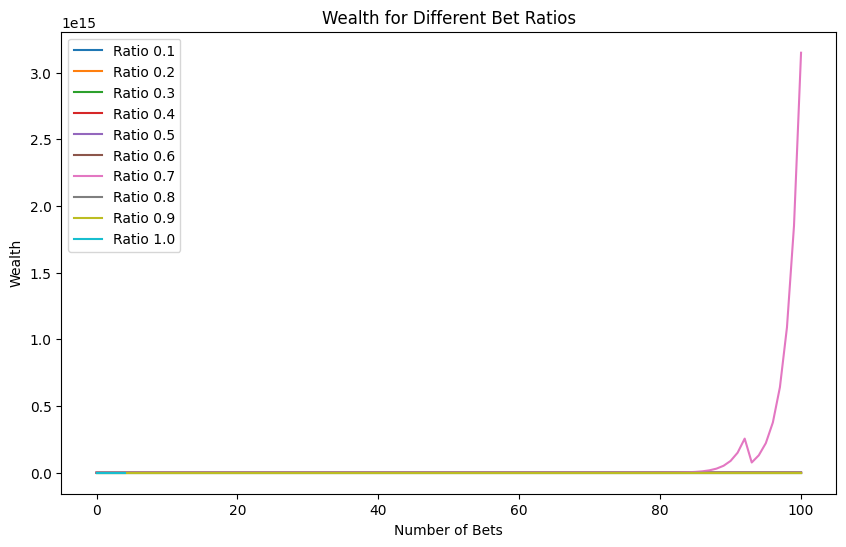

In [183]:
import matplotlib.pyplot as plt
import pandas as pd

# 設定變數
initial_wealth = 1000
bet_ratios = [i/10 for i in range(1, 11)]  # 從10%到全押的下注比例
num_bets = 100
win_rate =0.8

df = pd.DataFrame()
# 模擬各比例下注
for bet_ratio in bet_ratios:
  wealths = simulate_bets(initial_wealth, bet_ratio, win_rate, num_bets, verbose=False)
  df[f'Ratio {bet_ratio}'] = pd.Series(wealths)

final_wealths = df.iloc[-1]
max_ratio = final_wealths.idxmax() # 找到最好的下注比例
max_value = final_wealths.max()  # 最高資產

print(f"最好的下注比例為: {max_ratio}, 最終資產：{max_value}")

# 繪製圖表
ax = df.plot(figsize=(10,6), legend=True, title='Wealth for Different Bet Ratios')
ax.set_xlabel('Number of Bets')
ax.set_ylabel('Wealth')
plt.show()

### 5️⃣ 倍倍下注法

下注方法排名：
第1名:Ratio 0.6, 最終資產：240490760476040.44
第2名:Ratio 0.4, 最終資產：227613605269.99985
第3名:Ratio 0.5, 最終資產：116600606971.45903
第4名:Ratio 0.3, 最終資產：6667529129.070967
第5名:Ratio 0.7, 最終資產：92263120.26665083
第6名:Ratio 0.2, 最終資產：84056867.39414673
第7名:Ratio 0.8, 最終資產：3799030.613571716
第8名:Ratio 0.1, 最終資產：1240127.6971713903
第9名:double_bet, 最終資產：1077.0
第10名:Ratio 0.9, 最終資產：0.004243912982444718
第11名:Ratio 1.0, 最終資產：nan


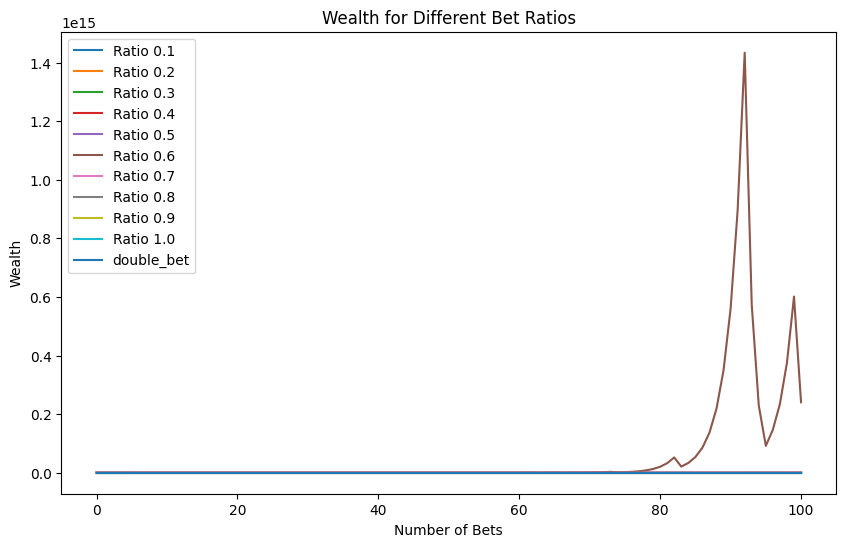

In [184]:
def double_bet(initial_wealth, win_rate, num_bets=100, odds=1):
  wealths = [initial_wealth]
  wealth = initial_wealth
  initial_bet = 1
  bet = initial_bet
  for i in range(num_bets):
    if random.uniform(0, 1) <= win_rate:
      # 若贏了，則下注初始金額
      wealth += bet * odds
      bet = initial_bet
    else:
      # 若輸了，則加倍下注金額
      wealth -= bet
      bet *= 2
    wealths.append(wealth)

    # 輸光就跳出迴圈
    if wealth <= 0:
      break

  return wealths

# 設定變數
initial_wealth = 1000
bet_ratios = [i/10 for i in range(1, 11)]  # 從10%到全押的下注比例
num_bets = 100
win_rate =0.8

df = pd.DataFrame()
# 模擬各比例下注
for bet_ratio in bet_ratios:
  wealths = simulate_bets(initial_wealth, bet_ratio, win_rate, num_bets, verbose=False)
  df[f'Ratio {bet_ratio}'] = pd.Series(wealths)

# 倍倍下注法模擬結果
wealths_double = double_bet(initial_wealth, win_rate, num_bets)
df['double_bet'] = pd.Series(wealths_double)

# 下注法排名
final_wealths = df.iloc[-1]
sorted_wealths = final_wealths.sort_values(ascending=False)
print("下注方法排名：")
i = 1
for index, value in zip(sorted_wealths.index, sorted_wealths.values):
    print(f"第{i}名:{index}, 最終資產：{value}")
    i += 1

# 繪製圖表
ax = df.plot(figsize=(10,6), legend=True, title='Wealth for Different Bet Ratios')
ax.set_xlabel('Number of Bets')
ax.set_ylabel('Wealth')
plt.show()

### 6️⃣ 凱利公式 Kelly formula

In [185]:
def kelly_formula(p,b):
  # 最佳下注比例
  best_bet = (b * p - (1 - p)) / b
  # 如果下注比例小於等於 0，則設為 0
  if best_bet <= 0:
      return 0
  # 取到小數點後兩位
  best_bet = round(best_bet,2)
  return best_bet

kelly_formula(p=0.8,b=1)

best_bet = kelly_formula(p=0.8, b=1)
print("最佳下注比例為:", best_bet)

最佳下注比例為: 0.6


### 7️⃣ 安裝及匯入套件

In [186]:
!pip install yfinance==0.2.38
!pip install backtesting
!pip install bokeh==2.4.3 # 繪圖套件
import yfinance as yf
import numpy as np
import pandas as pd # 資料處理套件
from scipy.stats import norm
import datetime as dt # 時間套件
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

### 8️⃣ 取得回測結果

In [187]:
# 取得股價資料
stock_id = "2330.tw"
df = yf.download(stock_id, period="5y")
df['ma1'] = df['Close'].rolling(window=5).mean()
df['ma2'] = df['Close'].rolling(window=10).mean()


# 定義回測策略
class CrossStrategy(Strategy):
  def init(self):
    super().init()

  def next(self):
    if crossover(self.data.ma1, self.data.ma2):
      self.buy(size=1)
    elif crossover(self.data.ma2, self.data.ma1):
      self.sell(size=1)


# 回測結果
backtest = Backtest(df,
        CrossStrategy,
        cash=100000,
        commission=0.004,
        margin=1,
        hedging=False,
        trade_on_close=False,
        exclusive_orders=False,
        )
stats = backtest.run()
print(stats)

[*********************100%%**********************]  1 of 1 completed

Start                     2020-01-16 00:00:00
End                       2025-01-16 00:00:00
Duration                   1827 days 00:00:00
Exposure Time [%]                   85.032895
Equity Final [$]                    99426.336
Equity Peak [$]                    100529.686
Return [%]                          -0.573664
Buy & Hold Return [%]              230.343797
Return (Ann.) [%]                   -0.119156
Volatility (Ann.) [%]                0.288714
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -1.132352
Avg. Drawdown [%]                   -0.095493
Max. Drawdown Duration      814 days 00:00:00
Avg. Drawdown Duration       84 days 00:00:00
# Trades                                   64
Win Rate [%]                           40.625
Best Trade [%]                      35.820355
Worst Trade [%]                    -21.024639
Avg. Trade [%]                    

### 9️⃣ 計算賠率、取得勝率及最佳下注比例

In [188]:
# 先計算出獲利及虧損時的平均報酬
def trades_returns(returns):
    profits = returns[returns > 0].tolist()
    losses = returns[returns < 0].tolist()

    # 確保分母不為零
    avg_profit = sum(profits) / len(profits) if profits else 0
    avg_loss = sum(losses) / len(losses) if losses else 0

    return avg_profit, avg_loss

avg_profit, avg_loss = trades_returns(stats['_trades']['ReturnPct'])
print(f"獲利時的平均報酬:{avg_profit*100:.2f}%")
print(f"虧損時的平均報酬:{avg_loss*100:.2f}%")
print("--------------------------")

# 用平均獲利除以平均虧損來推估賠率
b = -avg_profit/avg_loss
p = stats['Win Rate [%]']/100
print(f"賠率為:{b:.2f}")
print(f"勝率為:{p*100:.2f}%")
print("--------------------------")

# 代入凱利公式
best_bet = kelly_formula(p=p, b=b)
print("最佳下注比例為:", best_bet)

獲利時的平均報酬:7.17%
虧損時的平均報酬:-6.17%
--------------------------
賠率為:1.16
勝率為:40.62%
--------------------------
最佳下注比例為: 0


### 🔟 用凱利公式來更改策略

In [189]:
# 定義回測策略
class CrossStrategy(Strategy):
  kelly_ratio = 0.3  # 凱利公式的下注比率

  def init(self):
    super().init()

  def next(self):

    size = (self.equity * self.kelly_ratio) / self.data.Close[-1]
    size = max(round(size), 1) # 確保交易股數為整數

    if crossover(self.data.ma1, self.data.ma2):
        self.buy(size=size)
    elif crossover(self.data.ma2, self.data.ma1):
        self.sell(size=size)


# 回測結果
backtest = Backtest(df,
        CrossStrategy,
        cash=100000,
        commission=0.004,
        margin=1,
        hedging=False,
        trade_on_close=False,
        exclusive_orders=False,
        )
stats = backtest.run()
print(stats)

Start                     2020-01-16 00:00:00
End                       2025-01-16 00:00:00
Duration                   1827 days 00:00:00
Exposure Time [%]                   99.095395
Equity Final [$]                   119002.374
Equity Peak [$]                    143185.266
Return [%]                          19.002374
Buy & Hold Return [%]              230.343797
Return (Ann.) [%]                    3.671148
Volatility (Ann.) [%]                 8.16406
Sharpe Ratio                         0.449672
Sortino Ratio                        0.715064
Calmar Ratio                          0.21396
Max. Drawdown [%]                  -17.158115
Avg. Drawdown [%]                   -1.938011
Max. Drawdown Duration      631 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                  127
Win Rate [%]                         40.15748
Best Trade [%]                      44.828848
Worst Trade [%]                    -21.024639
Avg. Trade [%]                    

## 投資組合資金分配與風險管理

### 1️⃣1️⃣ 掛載雲端硬碟 & 安裝套件

In [190]:
!pip install gdown
import gdown
import os
!git clone https://github.com/FlagTech/F3933.git
%cd F3933
from Stock_DB import StockDB
%cd ..
from google.colab import drive
drive.mount('/content/drive')

fatal: destination path 'F3933' already exists and is not an empty directory.
/content/F3933
/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1️⃣2️⃣ 下載資料庫

In [191]:
# 指定下載路徑
!mkdir -p "/content/drive/MyDrive/StockGPT/"
output_path = '/content/drive/MyDrive/StockGPT/'

# 檢查資料庫是否存在
stock_db_path = output_path + 'stock.db'
if not os.path.exists(stock_db_path):
    print("下載資料庫中...")
    id = '1S5JE9ZF2hohRpvO8FikgLhQmN2DJrVgW'

    gdown.download(id=id, output=stock_db_path)
    print("下載完成")
else:
    print("無需下載")

無需下載


若需更新資料庫, 可執行以下程式碼

```
stock_db = StockDB()
stock_db.renew()
stock_db.close()
```



### 1️⃣3️⃣ 設定投資組合

In [192]:
# 以10檔股票為例
stock_list = [1101, 1203, 1216, 1402, 1722,
               1762, 2330, 2608, 2884, 6405]

condition = f"股號 IN ({','.join(map(str, stock_list))})"

# 從資料庫取出資料
stock_db = StockDB()
df = stock_db.get(table="日頻", where=condition)
df = df.dropna()
df.tail()

,股號,日期,開盤價,最高價,最低價,收盤價,還原價,成交量,殖利率,日本益比,股價淨值比,三大法人買賣超股數,融資買入,融卷賣出
24233,6405,2024-12-13,35.700001,35.700001,34.099998,34.599998,34.599998,1285053.0,0.29,-,0.97,"-41,465",68.0,23.0
24234,6405,2024-12-16,34.450001,34.500000,33.349998,33.650002,33.650002,897300.0,0.30,-,0.95,"336,533",70.0,39.0
24235,6405,2024-12-17,33.849998,34.299999,33.500000,33.849998,33.849998,539005.0,0.30,-,0.95,"-9,518",40.0,37.0
24236,6405,2024-12-18,33.849998,34.299999,33.200001,33.849998,33.849998,675000.0,0.30,-,0.95,"169,370",36.0,10.0
24237,6405,2024-12-19,32.900002,33.500000,32.900002,33.049999,33.049999,395200.0,0.30,-,0.93,"67,924",11.0,7.0


###1️⃣4️⃣ 計算每月的漲幅或跌幅

In [193]:
# 設定日期為索引
df['日期'] = pd.to_datetime(df['日期'])
df.set_index('日期', inplace=True)
df = df[df.index > '2017-01-01']

# 訓練資料與測試資料
start = "2021-01-01"
end = "2023-10-10"
train_df = df[df.index <= start]
test_df = df[(df.index > start) & (df.index <= end)]

# 取出每月最後一個交易日的收盤價
monthly_closing = train_df.groupby('股號')\
                          .resample('M')['收盤價'].last()

# 計算每月的漲幅或跌幅
monthly_return = monthly_closing.groupby(level=0)\
                                .pct_change().fillna(0)

print(monthly_return)

股號    日期        
1101  2017-01-31    0.000000
      2017-02-28    0.063559
      2017-03-31   -0.035857
      2017-04-30   -0.033058
      2017-05-31   -0.019943
                      ...   
6405  2020-08-31   -0.044855
      2020-09-30    0.038674
      2020-10-31   -0.061170
      2020-11-30    0.084986
      2020-12-31    0.120105
Name: 收盤價, Length: 480, dtype: float64


<ipython-input-193-0bb49d079779>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['收盤價'].last()


###1️⃣5️⃣ 計算每檔股票的最佳下注比例

In [194]:
results = []

# 計算每檔股票的最佳下注比例
for stock in stock_list:
    str_stock = str(stock)
    avg_profit, avg_loss = trades_returns(monthly_return[str_stock])
    b = -avg_profit/avg_loss # 賠率
    p = len(monthly_return[str_stock][monthly_return[str_stock] > 0]
            ) / len(monthly_return[str_stock])  # 勝率
    best_bet = kelly_formula(p=p, b=b) # 下注比例

    results.append([stock, avg_profit, avg_loss, p, b, best_bet])

# 合併為 DataFrame
df_results = pd.DataFrame(results,
              columns=['股號', '平均漲幅', '平均跌幅',
                  '勝率', '賠率', '下注比例'])

total_bet = df_results['下注比例'].sum()
df_results['資金分配'] = df_results['下注比例'] / total_bet

df_results

,股號,平均漲幅,平均跌幅,勝率,賠率,下注比例,資金分配
0,1101,0.042147,-0.033390,0.562500,1.262293,0.22,0.111111
1,1203,0.024024,-0.014281,0.625000,1.682224,0.40,0.202020
2,1216,0.040596,-0.033364,0.520833,1.216760,0.13,0.065657
3,1402,0.044509,-0.049732,0.562500,0.894973,0.07,0.035354
4,1722,0.037341,-0.038913,0.583333,0.959612,0.15,0.075758
5,1762,0.099330,-0.060044,0.520833,1.654290,0.23,0.116162
6,2330,0.067950,-0.047247,0.583333,1.438197,0.29,0.146465
7,2608,0.033360,-0.032416,0.500000,1.029125,0.01,0.005051
8,2884,0.036476,-0.043529,0.708333,0.837968,0.36,0.181818
9,6405,0.096346,-0.060858,0.458333,1.583135,0.12,0.060606


###1️⃣6️⃣ 比較平均分配與使用下注比例的報酬

In [195]:
# 計算測試資料的每月漲幅或跌幅
monthly_closing_test = test_df.groupby('股號')\
                .resample('M')['收盤價'].last()
monthly_return_test = monthly_closing_test.groupby(level=0)\
                                .pct_change().fillna(0)
first_price = monthly_closing_test.groupby('股號').first()
last_price = monthly_closing_test.groupby('股號').last()


# 計算報酬率
returns = (last_price /first_price)
df_results['股號'] = df_results['股號'].astype(str)
df_results_test = df_results.merge(
    returns.rename('報酬率'), left_on='股號', right_index=True)
display(df_results_test)

# 設定初始資金
initial_capital = 100000

# 平均分配策略的結果
avg = initial_capital / len(stock_list)
avg_strategy = sum(df_results_test['報酬率'] * avg)

# 使用下注比例的策略結果
bet_strategy = sum(df_results_test['報酬率'] *(
    df_results_test['資金分配'] * initial_capital))

print(f"平均分配策略的最終資金: {avg_strategy}")
print(f"下注比例策略的最終資金: {bet_strategy}")

<ipython-input-195-c1412ce8a405>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['收盤價'].last()
<ipython-input-195-c1412ce8a405>:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change().fillna(0)


,股號,平均漲幅,平均跌幅,勝率,賠率,下注比例,資金分配,報酬率
0,1101,0.042147,-0.033390,0.562500,1.262293,0.22,0.111111,0.898572
1,1203,0.024024,-0.014281,0.625000,1.682224,0.40,0.202020,1.166667
2,1216,0.040596,-0.033364,0.520833,1.216760,0.13,0.065657,1.010294
3,1402,0.044509,-0.049732,0.562500,0.894973,0.07,0.035354,1.098077
4,1722,0.037341,-0.038913,0.583333,0.959612,0.15,0.075758,1.208748
5,1762,0.099330,-0.060044,0.520833,1.654290,0.23,0.116162,1.099251
6,2330,0.067950,-0.047247,0.583333,1.438197,0.29,0.146465,0.900169
7,2608,0.033360,-0.032416,0.500000,1.029125,0.01,0.005051,0.899149
8,2884,0.036476,-0.043529,0.708333,0.837968,0.36,0.181818,1.215912
9,6405,0.096346,-0.060858,0.458333,1.583135,0.12,0.060606,1.284289


平均分配策略的最終資金: 107811.2775886113
下注比例策略的最終資金: 109524.21874729404


###1️⃣7️⃣ 與大盤績效進行比較

[*********************100%%**********************]  1 of 1 completed
<ipython-input-196-82a7fff6740d>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  market_closing = market_index.resample('M')['Close'].last()


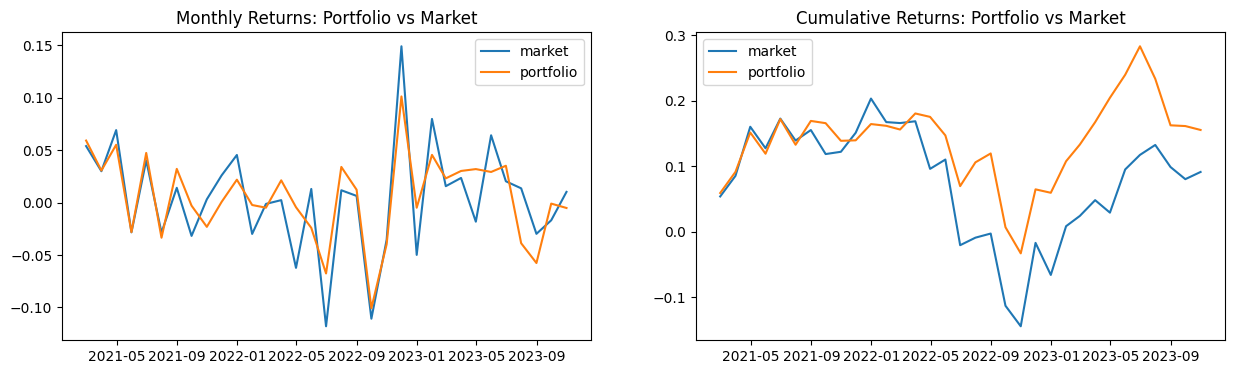

In [196]:
# 投組每月報酬
returns_df = pd.concat([monthly_return_test[str(stock)]
                         for stock in stock_list], axis=1)
returns_df.columns = stock_list
weights = df_results['資金分配'].values
returns_df['投組報酬'] = returns_df[stock_list].dot(weights)

# 計算大盤報酬
market_index = yf.download("^TWII",start=start,end=end)
market_closing = market_index.resample('M')['Close'].last()
market_return = market_closing.pct_change().fillna(0)
returns_df['大盤報酬'] = market_return

# 累積報酬
returns_df['投組累積報酬'] = (1 + returns_df['投組報酬']).cumprod() - 1
returns_df['大盤累積報酬'] = (1 + returns_df['大盤報酬']).cumprod() - 1

# 繪製大盤與投組績效
returns_df = returns_df.drop(returns_df.index[0])
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 4))

ax1.plot(returns_df['大盤報酬'], label="market")
ax1.plot(returns_df['投組報酬'], label="portfolio")
ax1.set_title("Monthly Returns: Portfolio vs Market")
ax1.legend()

ax2.plot(returns_df['大盤累積報酬'], label="market")
ax2.plot(returns_df['投組累積報酬'], label="portfolio")
ax2.set_title("Cumulative Returns: Portfolio vs Market")
ax2.legend()

plt.show()

###1️⃣8️⃣ 投資組合標準差 (σ)

In [197]:
# 計算共變異數矩陣
stk_returns_df = returns_df.iloc[:, :-4]
cov_matrix = stk_returns_df.cov()
display(cov_matrix)

# 計算投資組合的報酬與標準差
portfolio_return = np.dot(weights, stk_returns_df.mean().values)
portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))

# 轉換成年化
annualized_portfolio_return = (1 + portfolio_return)**12 - 1
annualized_portfolio_std = portfolio_std * (12**0.5)
annualized_market_return = (1 + market_return.mean())**12 - 1
annualized_market_std = market_return.std() * (12**0.5)

print(f"投資組合的年化報酬率:{annualized_portfolio_return*100:.2f}%")
print(f"投資組合的年化標準差:{annualized_portfolio_std*100:.2f}%")

print(f"大盤指數的年化報酬率:{annualized_market_return*100:.2f}%")
print(f"大盤指數的年化標準差:{annualized_market_std*100:.2f}%")

,1101,1203,1216,1402,1722,1762,2330,2608,2884,6405
1101,0.004561,0.000414,0.000602,0.001047,0.002989,0.002175,0.002499,0.001317,0.001795,0.001320
1203,0.000414,0.001502,0.000350,0.000535,0.000050,0.000820,0.001437,0.000246,0.000288,-0.000281
1216,0.000602,0.000350,0.001127,0.000170,0.000113,0.001444,0.000276,-0.000052,0.000293,-0.000408
1402,0.001047,0.000535,0.000170,0.002178,0.000612,0.001772,0.000339,0.000033,0.000619,0.002654
1722,0.002989,0.000050,0.000113,0.000612,0.004117,0.001316,0.001476,-0.000731,0.001803,0.002414
1762,0.002175,0.000820,0.001444,0.001772,0.001316,0.014119,0.002504,0.000869,0.001708,0.002995
2330,0.002499,0.001437,0.000276,0.000339,0.001476,0.002504,0.006524,0.001485,0.001875,0.001049
2608,0.001317,0.000246,-0.000052,0.000033,-0.000731,0.000869,0.001485,0.011438,-0.000281,0.003025
2884,0.001795,0.000288,0.000293,0.000619,0.001803,0.001708,0.001875,-0.000281,0.002324,0.001105
6405,0.001320,-0.000281,-0.000408,0.002654,0.002414,0.002995,0.001049,0.003025,0.001105,0.023437


投資組合的年化報酬率:6.42%
投資組合的年化標準差:14.12%
大盤指數的年化報酬率:4.70%
大盤指數的年化標準差:17.68%


###1️⃣9️⃣ 風險值 (Value at Risk, VaR)

In [198]:
confidence_level = 0.95

# 月頻 VaR
VaR = portfolio_return - portfolio_std * norm.ppf(confidence_level)
# 年頻 VaR
VaR_annualized = VaR * (12**0.5)

print(f"在 {confidence_level*100:.0f}% 的信心水準下,\
 下個月的最大可能損失為：{VaR*100:.2f}%")
print(f"在 {confidence_level*100:.0f}% 的信心水準下,\
 明年最大可能損失為：{VaR_annualized*100:.2f}%")

在 95% 的信心水準下, 下個月的最大可能損失為：-6.19%
在 95% 的信心水準下, 明年最大可能損失為：-21.43%


###2️⃣0️⃣ beta 係數 (β)


In [199]:
# 計算β係數
portfolio_market_cov = returns_df[['投組報酬', '大盤報酬']].cov()\
                               .iloc[0, 1]
market_var = returns_df['大盤報酬'].var()
portfolio_beta = portfolio_market_cov / market_var

print(f"投組與大盤的共變異數為：{portfolio_market_cov:.5f},\
    大盤變異數為：{market_var:.5f}")
print(f"投資組合的β係數：{portfolio_beta:.2f}")

投組與大盤的共變異數為：0.00177,    大盤變異數為：0.00269
投資組合的β係數：0.66


###2️⃣1️⃣ 夏普比率 (Sharpe Ratio)

In [200]:
# 設定無風險利率
risk_free_rate = 0.015/12  # 轉換成月頻 (算術平均)

average_return = returns_df['投組報酬'].mean()
portfolio_std = returns_df['投組報酬'].std()

sharpe_ratio = (average_return - risk_free_rate) / portfolio_std
sharpe_ratio_annualized = sharpe_ratio * (12**0.5)

print(f"投資組合的夏普比率：{sharpe_ratio:.2f}")
print(f"年化的夏普比率：{sharpe_ratio_annualized:.2f}")

投資組合的夏普比率：0.10
年化的夏普比率：0.34
